In [1]:
using Printf, Plots, Measures, LaTeXStrings, Statistics
using StatsBase:fit, Histogram
using MultimodeSelforganization

kwargs = (size=(1000,400),margin=5mm);

## Fig. 2 - Phase diagram

In [2]:
# analytical conditions for the existence of the local free energy minimum in the nematic phase
α_range = LinRange(0,3,500)
mags = [magnetization(CanonicalSys(α1 = 0., α2 = α2); u0 = [0.,0.5])[2] for α2 in α_range]
ana_cond1 = @. 1/(1 + mags)
ana_cond2 = @. 1/(1 - mags)

# determining the phase transition line
α2_range = LinRange(0.,3.,200)
transition_line = Float64[]
res = 2.
for α2 in α2_range
    start = minimum([1/(1 + magnetization(CanonicalSys(α1 = 0., α2 = α2); u0 = [0., 0.5])[2]), res]) + 1e-3
    res = canonical_phase_transition(start,α2)
    push!(transition_line,res)
end

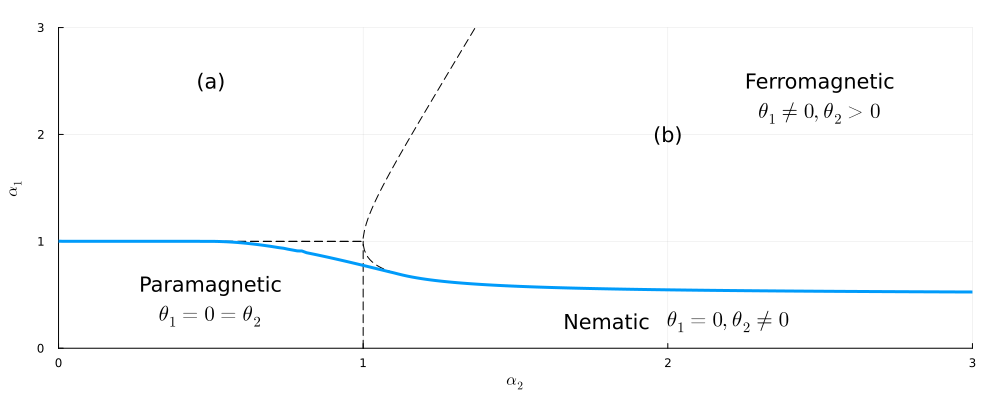

In [3]:
plot([1.,1.],[0.,1.],color=:black,ls=:dash,label="";kwargs...)
plot!(α_range,[ana_cond1 ana_cond2],color=:black,ls=:dash,xlims=(0,3),ylims=(0,3),label="")
plot!(α2_range,transition_line,color=1,lw=3,label="",xlabel = L"\alpha_2", ylabel = L"\alpha_1")
annotate!(0.5,0.6,"Paramagnetic"); annotate!(0.5,0.3,L"\theta_1 = 0 = \theta_2")
annotate!(1.8,0.25,"Nematic"); annotate!(2.2,0.25,L"\theta_1 = 0, \theta_2\neq 0")
annotate!(2.5,2.5,"Ferromagnetic"); annotate!(2.5,2.2,L"\theta_1\neq 0, \theta_2 > 0")
annotate!(0.5,2.5,"(a)"); annotate!(2.,2.,"(b)")

In [4]:
# plotting the free energy at points (a) and (b)
θ_range = LinRange(-1,1,200)
thresh = -1.87
F_ferro = [free_energy([θ1,θ2],CanonicalSys(α1 = 2.5, α2 = 0.5)) for θ1 in θ_range, θ2 in θ_range]
F_ferro[F_ferro.>thresh] .= NaN
F_mixed = [free_energy([θ1,θ2],CanonicalSys(α1 = 2., α2 = 2.)) for θ1 in θ_range, θ2 in θ_range]
F_mixed[F_mixed.>thresh] .= NaN;

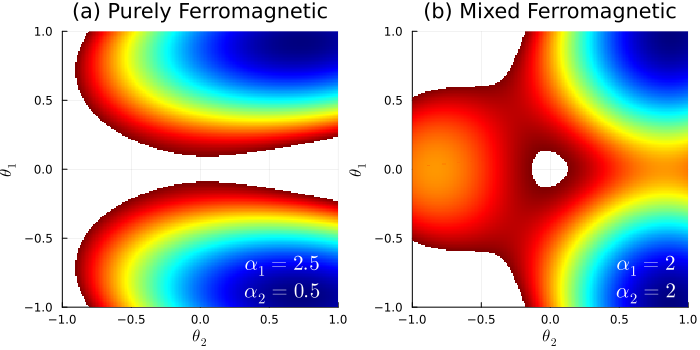

In [5]:
p1 = heatmap(θ_range,θ_range,F_ferro,cmap=:jet,cbar=:none,title="(a) Purely Ferromagnetic")
annotate!(0.6,-0.7,L"\alpha_1=2.5",:white)
annotate!(0.6,-0.9,L"\alpha_2=0.5",:white)

p2 = heatmap(θ_range,θ_range,F_mixed,cmap=:jet,cbar=:none,title="(b) Mixed Ferromagnetic") 
annotate!(0.7,-0.7,L"\alpha_1=2",:white)
annotate!(0.7,-0.9,L"\alpha_2=2",:white)

plot(p1,p2, ratio=:equal, xlims=(-1,1), ylims=(-1,1), xlabel = L"\theta_2", ylabel = L"\theta_1", size=(700,350))

In the microcanonical ensemble the resulting steady-state magnetizations are smaller and the structure of two global extrema in the purely ferromagnetic phase and an additional local extremum in the nematic phase in the mixed case becomes clearer when plotting the entropy. 

In [6]:
# plotting the entropy at points (a) and (b)
θ_range = LinRange(-1,1,100)
thresh = 3.2
S_ferro = [entropy([θ1,θ2],MicrocanonicalSys(α1 = 2.5, α2 = 0.5)) for θ1 in θ_range, θ2 in θ_range]
S_ferro[S_ferro.<thresh] .= NaN
S_mixed = [entropy([θ1,θ2],MicrocanonicalSys(α1 = 2., α2 = 2.)) for θ1 in θ_range, θ2 in θ_range]
S_mixed[S_mixed.<thresh] .= NaN;

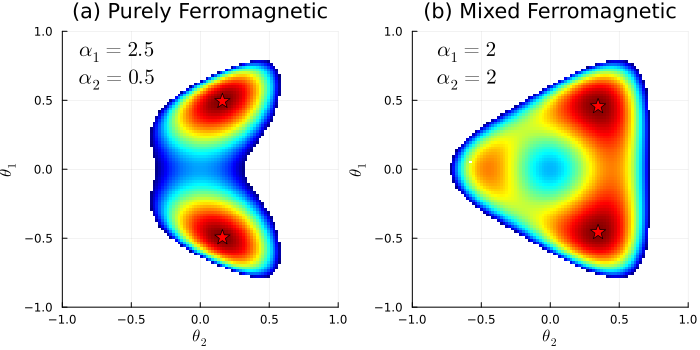

In [7]:
p1 = heatmap(θ_range,θ_range,S_ferro,cmap=:jet,cbar=:none,title="(a) Purely Ferromagnetic")
mag = magnetization(MicrocanonicalSys(α1 = 2.5, α2 = 0.5))
scatter!([mag[2],mag[2]],[mag[1],-mag[1]], marker=:star,mc=:red, ms=8, legend=:none)
annotate!(-0.6,0.85,L"\alpha_1=2.5")
annotate!(-0.6,0.65,L"\alpha_2=0.5")

p2 = heatmap(θ_range,θ_range,S_mixed,cmap=:jet,cbar=:none,title="(b) Mixed Ferromagnetic")
mag = magnetization(MicrocanonicalSys(α1 = 2., α2 = 2.))
scatter!([mag[2],mag[2]],[mag[1],-mag[1]], marker=:star,mc=:red, ms=8, legend=:none)
annotate!(-0.6,0.85,L"\alpha_1=2")
annotate!(-0.6,0.65,L"\alpha_2=2")

plot(p1,p2, ratio=:equal, xlims=(-1,1), ylims=(-1,1), xlabel = L"\theta_2", ylabel = L"\theta_1", size=(700,350))

## Fig. 3 - Trajectory statistics for a single quench into the ferromagnetic phase

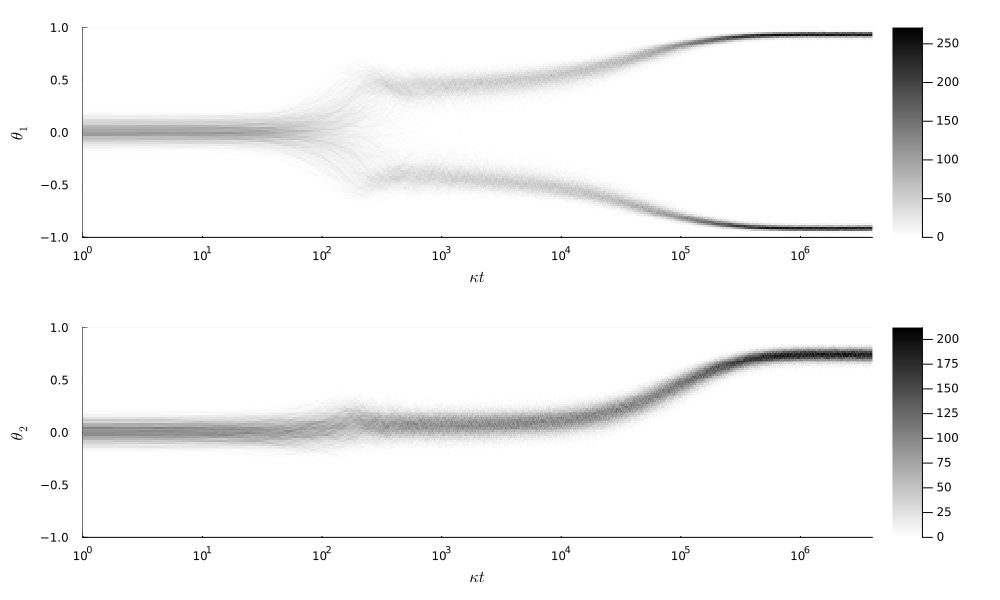

In [8]:
N, α1, α2, trajectories = 100, 2.5, 0.5, 1000
fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,trajectories)
sim = load_data(fname)

bin_range = range(-1,1,length=112)
θ1_hist = zeros(length(bin_range)-1,length(sim.snapshots))
θ2_hist = zeros(length(bin_range)-1,length(sim.snapshots))
    
for i = 1:length(sim.snapshots)
    θ1_data = sim.data[1].data[i,:]
    hist1 = fit(Histogram,θ1_data,bin_range)
    θ1_hist[:,i] = hist1.weights
    θ2_data = sim.data[2].data[i,:]
    hist2 = fit(Histogram,θ2_data,bin_range)
    θ2_hist[:,i] = hist2.weights
end

p1 = heatmap(sim.t,bin_range[2:end],θ1_hist,c=cgrad(:bone,rev=true),ylabel=L"\theta_1")
p2 = heatmap(sim.t,bin_range[2:end],θ2_hist,c=cgrad(:bone,rev=true),ylabel=L"\theta_2")
plot(p1,p2,layout=(2,1),xscale=:log10,xlabel=L"\kappa t",xlims=(1,sim.tf),ylims=(-1,1),xticks=10.0.^(0:7),size=(1000,600),margin=5mm)

## Fig. 4/5 - Quenching into the ferromagnetic phase for varying N

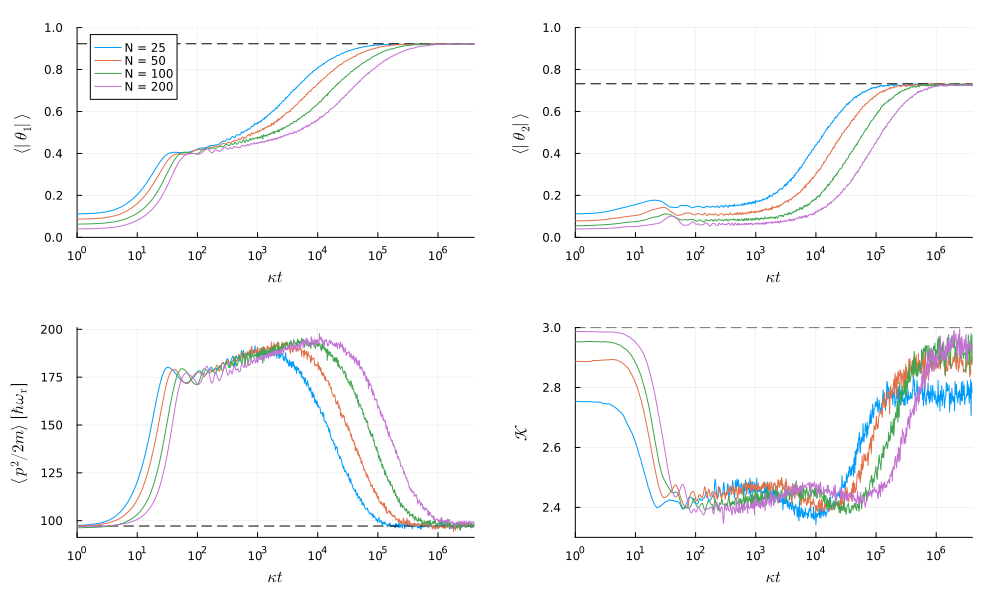

In [9]:
N_range = [25, 50, 100, 200]
α1, α2 = 2.5, 0.5
sims = Simulation[]
for N in N_range
    trajectories = Int(25e3/N)
    fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,trajectories)
    push!(sims,load_data(fname))
end
plot_observables(sims)

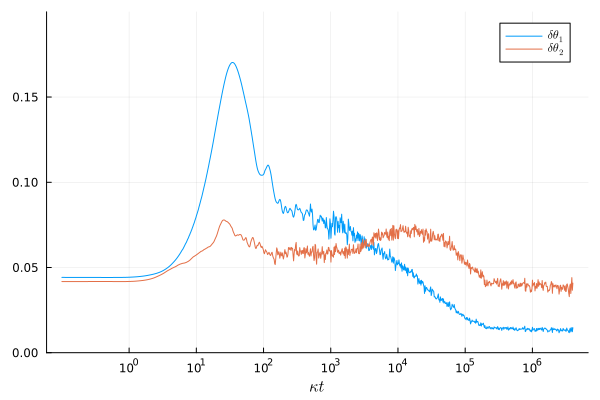

In [10]:
N = 100
α1, α2 = 2.5, 0.5
trajectories = Int(25e3/N)
fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,trajectories)
sim = load_data(fname)

θ1 = sim.data[findfirst(obs -> obs.name == :θ1,sim.data)].data
θ2 = sim.data[findfirst(obs -> obs.name == :θ2,sim.data)].data
δθ1 = sqrt.(mean(θ1.^2,dims=2) .- mean(abs.(θ1),dims=2).^2) 
δθ2 = sqrt.(mean(θ2.^2,dims=2) .- mean(abs.(θ2),dims=2).^2) 

plot(sim.t,[δθ1 δθ2],label=[L"\delta\theta_1" L"\delta\theta_2"],xscale=:log10,xticks=10 .^(0:7),xlabel=L"\kappa t",ylims=(0.,0.2))

## Fig. 6 - Quenching into the ferromagnetic phase for varying α

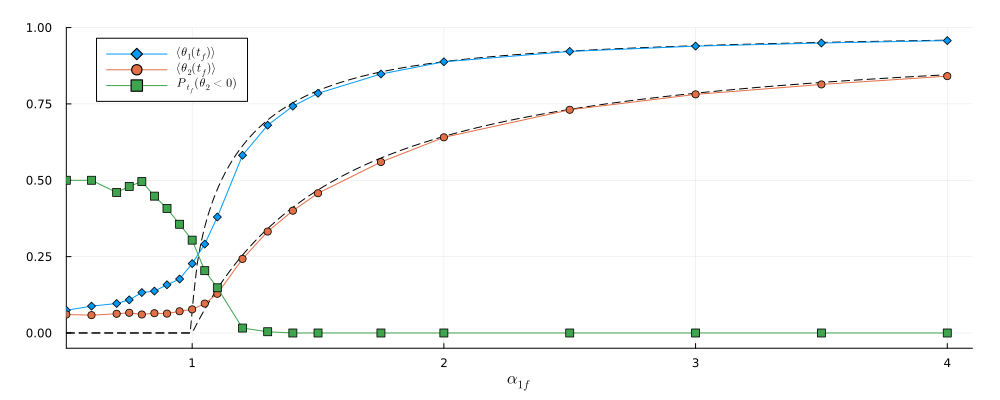

In [11]:
α_range_ana = LinRange(0.5,4,250) 
α_range = [0.50, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1., 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.75, 2., 2.5, 3., 3.5, 4.]
trajectories = 250
θ1_ana = []
θ2_ana = []
θ1_num = []
θ2_num = []
probs = []
for α in α_range_ana
    sys = CanonicalSys(N = 100, α1 = α, α2 = α/5)
    mag = magnetization(sys)
    push!(θ1_ana,mag[1]); push!(θ2_ana,mag[2])
end
for α in α_range
    fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",100,α,α/5,trajectories)
    sim = load_data(fname)
    data = ensemble_average(sim)
    val1 = data[1].data[end]
    val2 = data[2].data[end]
    push!(θ1_num,val1)
    push!(θ2_num,val2)
    prob = sum([1 for i = 1:sim.trajectories if sim.data[2].data[end,i]< 0])/sim.trajectories
    push!(probs,prob)
end

plot(α_range_ana,[θ1_ana θ2_ana],color=:black,ls=:dash,xlims=(0.5,4.1),ylims=(-0.05,1),label="",xlabel=L"\alpha_{1f}"; kwargs...)
plot!(α_range,[θ1_num θ2_num probs],color=[1 2 3], marker=[:diamond :circle :square], label=[L"\langle\theta_1(t_f)\rangle" L"\langle\theta_2(t_f)\rangle" L"P_{t_f}(\theta_2 < 0)"])

## Fig. 7 - Trajectory statistics for a single quench into the mixed phase

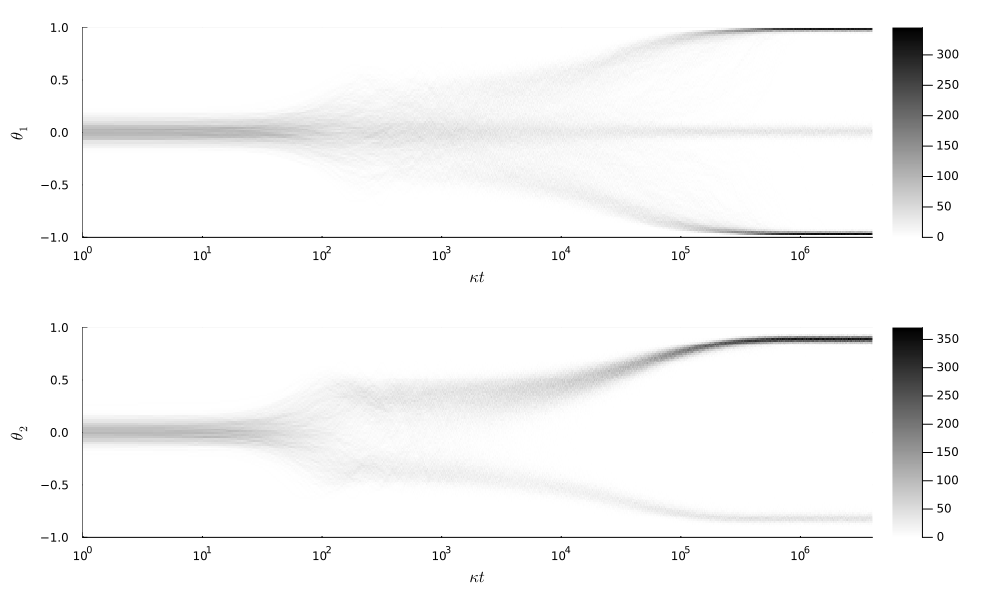

In [12]:
N, α1, α2, trajectories = 100, 2., 2., 1000
fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,trajectories)
sim = load_data(fname)

bin_range = range(-1,1,length=112)
θ1_hist = zeros(length(bin_range)-1,length(sim.snapshots))
θ2_hist = zeros(length(bin_range)-1,length(sim.snapshots))
    
for i = 1:length(sim.snapshots)
    θ1_data = sim.data[1].data[i,:]
    hist1 = fit(Histogram,θ1_data,bin_range)
    θ1_hist[:,i] = hist1.weights
    θ2_data = sim.data[2].data[i,:]
    hist2 = fit(Histogram,θ2_data,bin_range)
    θ2_hist[:,i] = hist2.weights
end

p1 = heatmap(sim.t,bin_range[2:end],θ1_hist,c=cgrad(:bone,rev=true),ylabel=L"\theta_1")
p2 = heatmap(sim.t,bin_range[2:end],θ2_hist,c=cgrad(:bone,rev=true),ylabel=L"\theta_2")
plot(p1,p2,layout=(2,1),xscale=:log10,xlabel=L"\kappa t",xlims=(1,sim.tf),ylims=(-1,1),xticks=10.0.^(0:7),size=(1000,600),margin=5mm)

## Fig. 8/9 - Quenching into the mixed phase for varying N

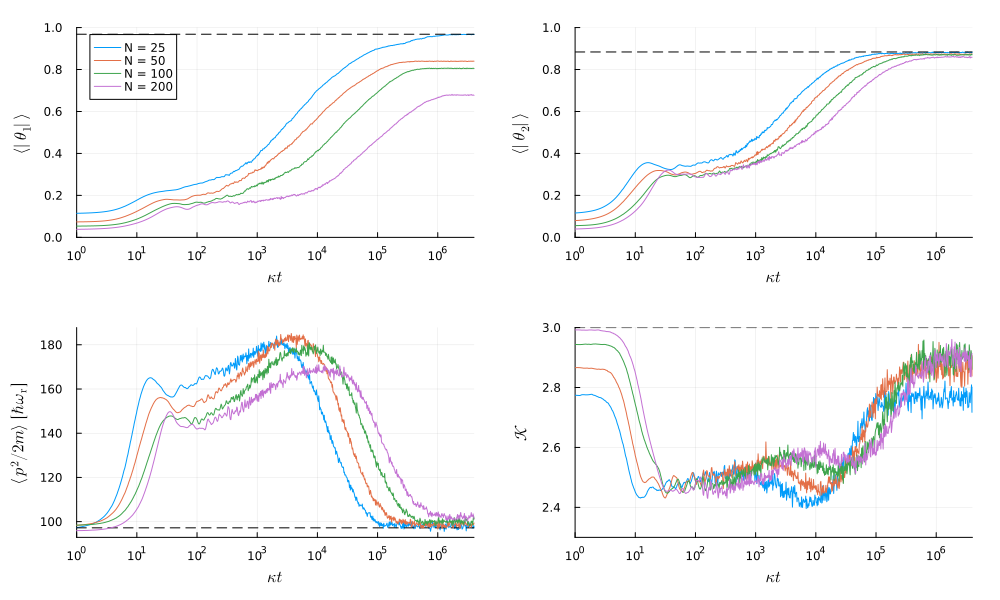

In [13]:
N_range = [25, 50, 100, 200]
α1, α2 = 2.0, 2.0
sims = Simulation[]
for N in N_range
    trajectories = Int(25e3/N)
    fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,trajectories)
    push!(sims,load_data(fname))
end
plot_observables(sims)

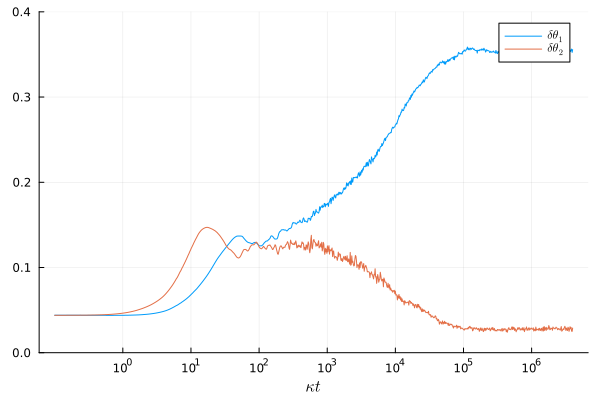

In [14]:
N = 100
α1, α2 = 2., 2.
trajectories = Int(25e3/N)
fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,trajectories)
sim = load_data(fname)

θ1 = sim.data[findfirst(obs -> obs.name == :θ1,sim.data)].data
θ2 = sim.data[findfirst(obs -> obs.name == :θ2,sim.data)].data
δθ1 = sqrt.(mean(θ1.^2,dims=2) .- mean(abs.(θ1),dims=2).^2) 
δθ2 = sqrt.(mean(θ2.^2,dims=2) .- mean(abs.(θ2),dims=2).^2)

plot(sim.t,[δθ1 δθ2],label=[L"\delta\theta_1" L"\delta\theta_2"],xscale=:log10,xticks=10 .^(0:7),xlabel=L"\kappa t",ylims=(0.,0.4))

## Fig. 10 - Quenching into the mixed phase for varying α

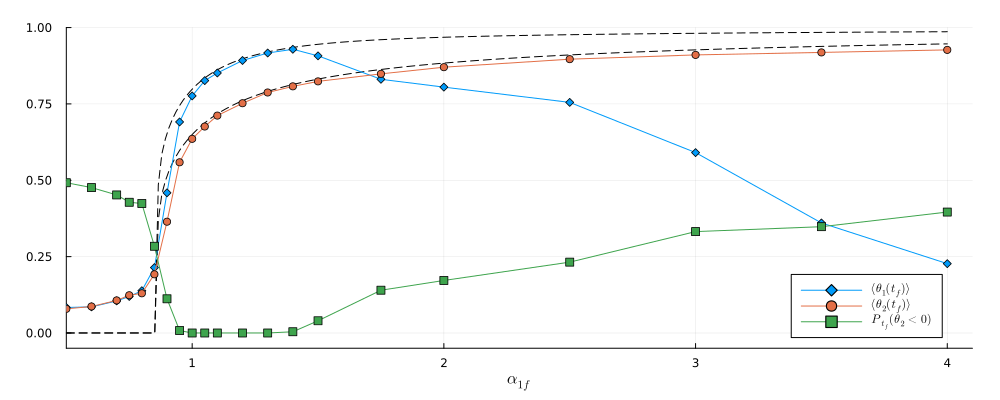

In [15]:
α_range_ana = LinRange(0.5,4,250) 
α_range = [0.50, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1., 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.75, 2., 2.5, 3., 3.5, 4.]
trajectories = 250
θ1_ana = []
θ2_ana = []
θ1_num = []
θ2_num = []
probs = []
for α in α_range_ana
    sys = CanonicalSys(N = 100, α1 = α, α2 = α)
    mag = magnetization(sys)
    push!(θ1_ana,mag[1]); push!(θ2_ana,mag[2])
end
for α in α_range
    fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",100,α,α,trajectories)
    sim = load_data(fname)
    data = ensemble_average(sim)
    val1 = data[1].data[end]
    val2 = data[2].data[end]
    push!(θ1_num,val1)
    push!(θ2_num,val2)
    prob = sum([1 for i = 1:sim.trajectories if sim.data[2].data[end,i]< 0])/sim.trajectories
    push!(probs,prob)
end

plot(α_range_ana,[θ1_ana θ2_ana],color=:black,ls=:dash,xlims=(0.5,4.1),ylims=(-0.05,1),label="",xlabel=L"\alpha_{1f}"; kwargs...)
plot!(α_range,[θ1_num θ2_num probs],color=[1 2 3], marker=[:diamond :circle :square], label=[L"\langle\theta_1(t_f)\rangle" L"\langle\theta_2(t_f)\rangle" L"P_{t_f}(\theta_2 < 0)"])

## Fig. 11/12 - Slow ramps into the mixed phase: observables

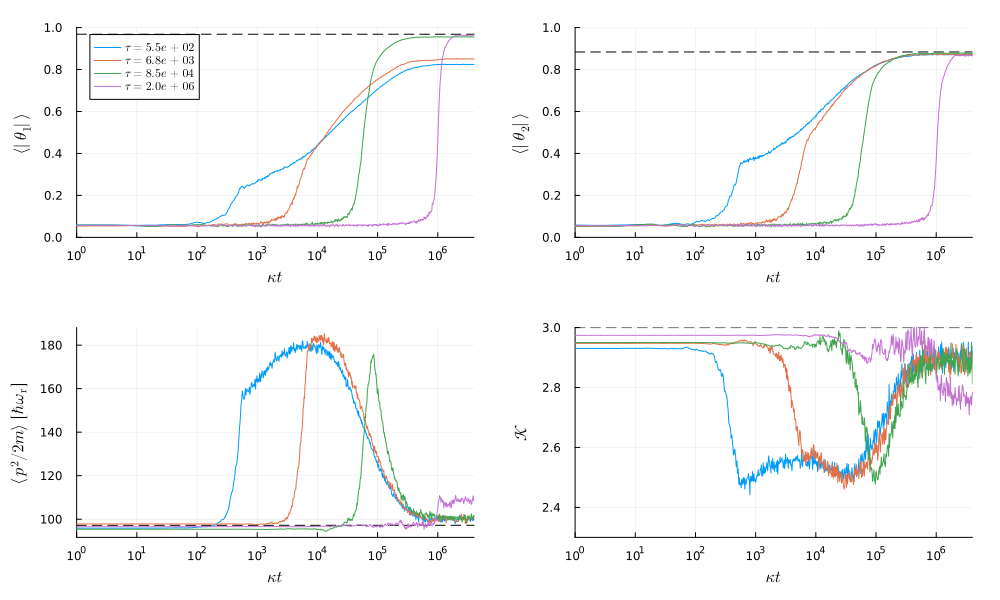

In [16]:
N, α1, α2, trajectories = 100, 2., 2., 250
τ_range = [5.5e2, 6.8e3, 8.5e4, 2e6]
sims = Simulation[]
for τ in τ_range 
    fname = @sprintf("data/ramp_tau_%.1e_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",τ,N,α1,α2,trajectories)
    push!(sims,load_data(fname))
end
plot_observables(sims; labels = [latexstring(@sprintf("\\tau = %.1e",τ)) for τ in τ_range])

## Fig. 13 - Slow ramps into the mixed phase: final magnetizations

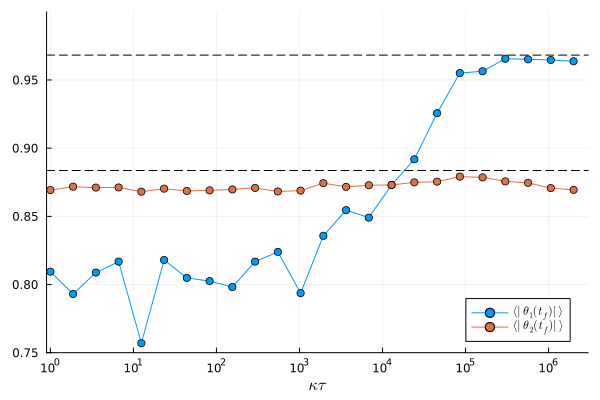

In [17]:
N, α1, α2, trajectories = 100, 2., 2., 250
τ_range = 10.0.^LinRange(0,log10(2) + 6,24)
θ1_num = []
θ2_num = []
for τ in τ_range
    fname = @sprintf("data/ramp_tau_%.1e_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU.jls",τ,N,α1,α2,trajectories)
    sim = load_data(fname)
    data = ensemble_average(sim)
    push!(θ1_num,data[1].data[end])
    push!(θ2_num,data[2].data[end])
end
plot(τ_range,[θ1_num θ2_num], marker =:circle, label=[L"\langle|\theta_1(t_f)|\rangle" L"\langle|\theta_2(t_f)|\rangle"], xscale=:log10,xlims=(0.9,3e6),ylims=(0.75,1.),xlabel=L"\kappa\tau")
θ1, θ2 = magnetization(CanonicalSys(α1 = α1, α2 = α2))
hline!([θ1 θ2],ls=:dash,color=:black,label="")

## Fig. 14/15 - Two-step quenches into the mixed phase: observables

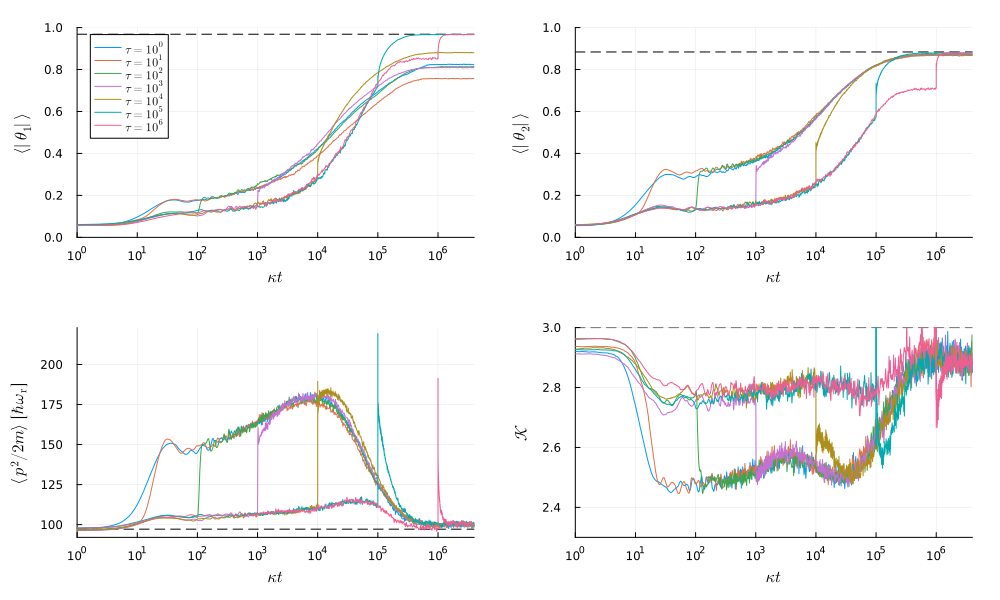

In [18]:
N, α1, α2, trajectories = 100, 2., 2., 250
τ_range = 10.0.^collect(0:6)
sims = Simulation[]
for τ in τ_range
    fname1 = @sprintf("data/two_step_quench_tau_%.1e_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU_part1.jls",τ,N,α1,α2,trajectories)
    sim1 = load_data(fname1)
    fname2 = @sprintf("data/two_step_quench_tau_%.1e_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU_part2.jls",τ,N,α1,α2,trajectories)
    sim2 = load_data(fname2)
    push!(sims,join_simulations(sim1,sim2))
end
plot_observables(sims; labels = [L"τ = 10^%$(expo)" for expo in Int.(log10.(τ_range))])

## Fig. 16 - Two-step quenches into the mixed phase: final magnetization

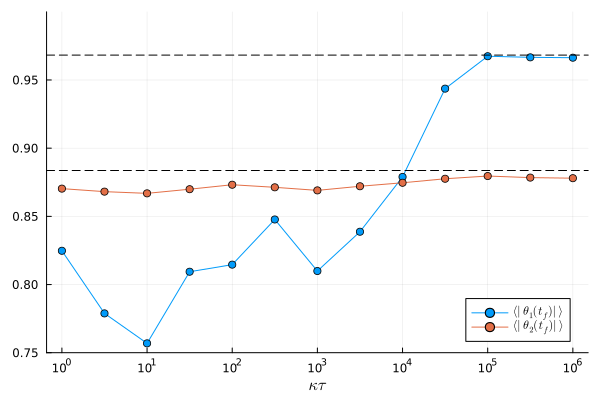

In [19]:
N, α1, α2, trajectories = 100, 2., 2., 250
τ_range = 10.0.^LinRange(0,6,13)
θ1_num = []
θ2_num = []
for τ in τ_range
    fname1 = @sprintf("data/two_step_quench_tau_%.1e_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU_part1.jls",τ,N,α1,α2,trajectories)
    sim1 = load_data(fname1)
    fname2 = @sprintf("data/two_step_quench_tau_%.1e_N%d_alpha1_%2.2f_alpha2_%2.2f_tf_4e6_trajectories_%d_GPU_part2.jls",τ,N,α1,α2,trajectories)
    sim2 = load_data(fname2)
    data = ensemble_average(join_simulations(sim1,sim2))
    push!(θ1_num,data[1].data[end])
    push!(θ2_num,data[2].data[end])
end

plot(τ_range,[θ1_num θ2_num], marker =:circle, label=[L"\langle|\theta_1(t_f)|\rangle" L"\langle|\theta_2(t_f)|\rangle"], xscale=:log10,ylims=(0.75,1.),xlabel=L"\kappa\tau")
θ1, θ2 = magnetization(CanonicalSys(α1 = α1, α2 = α2))
hline!([θ1 θ2],ls=:dash,color=:black,label="")

## Fig. 17/18 - Quenching into the mixed phase for varying initial temperature: observables

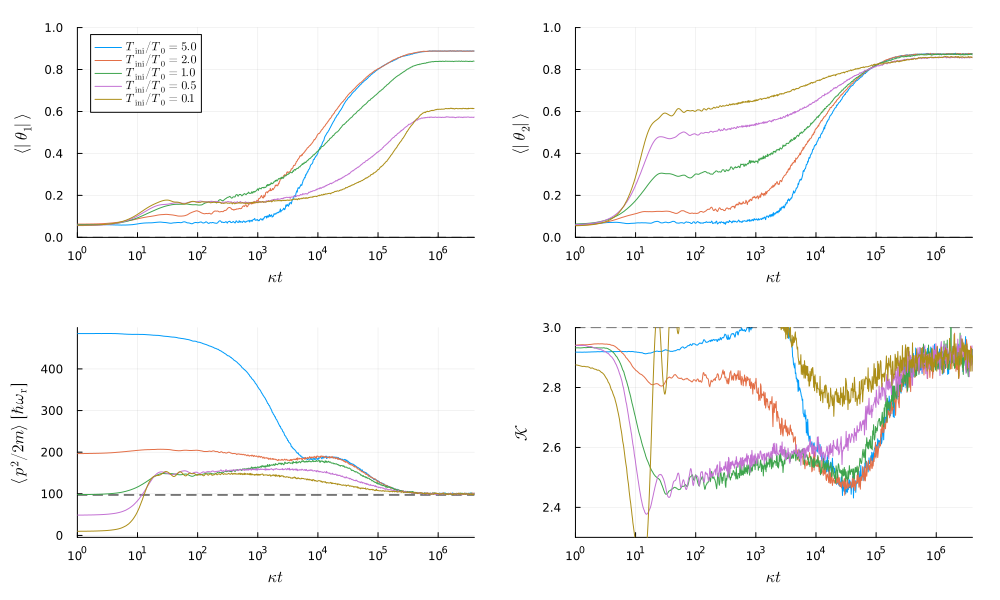

In [20]:
N = 100
trajectories = Int(25e3/N)
α1, α2 = 2., 2.
T_range = [5, 2, 1, 0.5, 0.1]    
sims = Simulation[]
for T in T_range
    fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_temperature_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,T,trajectories)
    push!(sims,load_data(fname))
end
plot_observables(sims; labels = [L"T_\mathrm{ini} / T_0 = %$(T)" for T in T_range])

## Fig. 19 - Quenching into the mixed phase for varying initial temperatures: final magnetization 

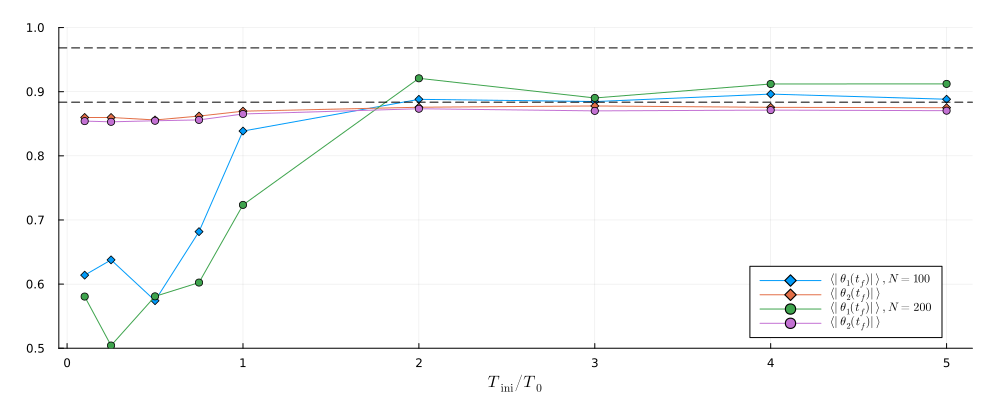

In [21]:
T_range = [0.1, 0.25, 0.5, 0.75, collect(1:5)...]
α1 = 2.
α2 = 2.
θ1_num = []
θ2_num = []
for T in T_range
    for N in [100, 200]
        trajectories = Int(25e3/N)
        fname = @sprintf("data/quench_N%d_alpha1_%2.2f_alpha2_%2.2f_temperature_%2.2f_tf_4e6_trajectories_%d_GPU.jls",N,α1,α2,T,trajectories)
        sim = load_data(fname)
        data = ensemble_average(sim)
        val1 = data[1].data[end]
        val2 = data[2].data[end]
        push!(θ1_num,val1)
        push!(θ2_num,val2)
  end
end
plot(T_range,[θ1_num[1:2:end] θ2_num[1:2:end] θ1_num[2:2:end] θ2_num[2:2:end]],marker=[:diamond :diamond :circle :circle],xlabel=L"T_\mathrm{ini}/T_0",label=[L"\langle|\theta_1(t_f)|\rangle\; , N = 100" L"\langle|\theta_2(t_f)|\rangle" L"\langle|\theta_1(t_f)|\rangle\; , N=200" L"\langle|\theta_2(t_f)|\rangle"],ylims=(0.5,1.); kwargs...)
θ1, θ2 = magnetization(CanonicalSys(α1 = α1, α2 = α2))
hline!([θ1 θ2],ls=:dash,color=:black,label="")